## Introduction to big data tools

Python packages like numpy, pandas, sklearn, seaborn etc. make the data manipulation and ML tasks very convenient. For most data analysis tasks, the python pandas package is good enough. You can do all sorts of data manipulation and it is compatible with building ML models.

But, as your data gets bigger, bigger than what you can fit in the RAM, pandas won’t be sufficient. When it comes to working with really large datasets, the run time can become very high due to memory constraints. The standard libraries like pandas and numpy usually work well if the dataset is small enough (upto 2-3 GBs). Unfortunately, these popular libraries were not designed to scale beyond a single machine and given a large dataset to analyze (like 8/16/32  GB or beyond), it would be difficult to process and model it using standard means. 

## Dask

Dask is popularly known as a ‘parallel computing’ python library that has been designed to run across multiple systems. Dask can efficiently perform parallel computations on a single machine using multi-core CPUs. For example, if you have a quad core processor, Dask can effectively use all 4 cores of your system simultaneously for processing. In order to use lesser memory during computations, Dask keeps the complete data on the disk, and uses chunks of data (smaller parts, rather than the whole data) from the disk for processing. During the processing, the intermediate values generated (if any) are discarded as soon as possible, to save the memory consumption.

This way Dask supports the Pandas dataframe and Numpy array data structures to analyze large datasets. Basically, Dask lets you scale pandas and numpy with minimum changes in your code format.

Installation: https://docs.dask.org/en/latest/install.html

Some additional resources for diving deeper into Dask and common operations:

#### Dask documentation: https://docs.dask.org/en/latest/

#### Detailed book/tutorial: https://livebook.manning.com/book/data-science-at-scale-with-python-and-dask/about-this-book/

#### Parallel computing: https://ckyrkou.medium.com/an-introduction-to-parallel-computing-dffa6b79e57c

In [36]:
import pandas as pd
import numpy as np
import geopandas as gpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
from matplotlib import pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Dask arrays

A large numpy array is divided into smaller arrays which, when grouped together, form the Dask array. In simple words, Dask arrays are distributed numpy arrays. Every operation on a Dask array triggers operations on the smaller numpy arrays, each using a core on the machine. Thus all available cores are used simultaneously enabling computations on arrays which are larger than the memory size.

<img src="array.png" width="500">


A number of numpy arrays are arranged into grids to form a Dask array. While creating a Dask array, you can specify the chunk size which defines the size of the numpy arrays. For instance, if you have 10 values in an array and you give the chunk size as 5, it will return 2 numpy arrays with 5 values each.

In [2]:
import dask.array as da
# example
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

This creates a 10000x10000 array of random numbers uniformly distrubuted between 0 and 1. The full object would contain 100M numbers - not impossible, but challenging to handle as a single variable.

Dask would represent it as many numpy arrays of size specified by chunk=1000x1000 (or smaller if the array cannot be divided evenly). 

In this case there are 100 (10x10) numpy arrays of size 1000x1000.

The 'compute()' function changes the result to a numpy array. If you don't call compute, the output remains as a dask object storing the sequency of suggested computations, but not running those just yet ("lazy" approach).

#### Important Note: 

Before calling the compute() function, any dask object remains what is called a Dask 'collection', which essentially stores all the computations called before but not actually performs them. With the compute method, all computations called before are performed simultaneously and the object transform from a dask collection to a concrete value in local memory.

It is thus important to know when and when not to call the compute method. The approach often breaks down if we try to bring the entire dataset as output back to local RAM. So if are dealing with data that exceeds machine RAM, it is better not to obtain the entire data as output. However, we can still call the compute method for obtaining low-memory outputs like computations for selected arrays (or columns in a dataframe) or aggregations.

In [5]:
x.compute()

array([[0.29653447, 0.43131085, 0.37298345, ..., 0.90632792, 0.37869041,
        0.50675453],
       [0.81302411, 0.17387528, 0.848152  , ..., 0.53977867, 0.76026503,
        0.75954449],
       [0.53122646, 0.56568247, 0.28361891, ..., 0.33282537, 0.63752668,
        0.67216828],
       ...,
       [0.61311915, 0.19781427, 0.98775041, ..., 0.78681004, 0.94992171,
        0.7650614 ],
       [0.83581085, 0.59416967, 0.84150185, ..., 0.57660925, 0.99142219,
        0.77554088],
       [0.2167564 , 0.67440457, 0.51694412, ..., 0.81522757, 0.43800305,
        0.97738486]])

### Persist data in memory
If you know you have the available RAM for your dataset then you can persist data in memory. Essentially this operation temporarily saves the data in your computer memory if the size of the data does not exceed your RAM.

This allows future computations to be much faster. 

Let's check how much time does it take to calculate sum of the above array

In [4]:
# calculate sum and call compute to print the output
%time x.sum().compute()

CPU times: user 1.02 s, sys: 40.4 ms, total: 1.06 s
Wall time: 185 ms


49998710.80312676

In [5]:
# now let's try the persist() function and then check the time
y = x.persist()
%time y.sum().compute()

CPU times: user 203 ms, sys: 7.66 ms, total: 210 ms
Wall time: 47.7 ms


49998710.80312676

The computation time almost reduces to 1/10th of the original time after calling the persist() function

### Dask dataframes

We saw that multiple numpy arrays are grouped together to form a Dask array. Similar to a Dask array, a Dask dataframe consists of multiple smaller pandas dataframes which are stored in disk/cluster as a single dask object. These Pandas DataFrames may live on disk for computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.

A large pandas dataframe splits row-wise to form multiple smaller dataframes. These smaller dataframes are present on a disk of a single machine, or multiple machines (thus allowing to store datasets of size larger than the memory). Each computation on a Dask dataframe parallelizes operations over the different chunks on the dataframe.


<img src="dataframe.png" width="300">


### Common uses:

Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed.

1. Manipulating large datasets, even when those datasets don’t fit in memory
2. Accelerating long computations by using many cores
3. Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

The APIs offered by the Dask dataframe are very similar in syntax to that of the pandas dataframe.

#### Now, let’s perform some basic operations on Dask dataframes

Let's download 2020 January TLC yellow taxi data. Generally, TLC data contains millions of records even for a single month and pandas usually has a hard time reading and performing computations on it. Anyway, pandas either altogether fails to load data for multiple months or takes a huge time reading it.

In [3]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  566M  100  566M    0     0   536k      0  0:17:59  0:17:59 --:--:--  810k0  0:37:06  0:00:03  0:37:03  260k 447k      0  0:21:34  0:00:43  0:20:51  663k04  0:02:27  0:19:37  477k1:27  0:02:57  0:18:30  534k     0   450k      0  0:21:26  0:03:11  0:18:15  356k.0M    0     0   445k      0  0:21:41  0:03:29  0:18:12  492k49  0:03:40  0:18:09  352k66M   18  107M    0     0   441k      0  0:21:54  0:04:09  0:17:45  336k  19  109M    0     0   442k      0  0:21:49  0:04:14  0:17:35  512kM    0     0   449k      0  0:21:29  0:04:30  0:16:59  514k1  121M    0     0   451k      0  0:21:23  0:04:34  0:16:49  591k  25  142M    0     0   463k      0  0:20:50  0:05:15  0:15:35  695kM    0     0   471k      0  0:20:28  0:05:39  0:14:49  611k 0  0:20:31  0:06:24  0:14:07  345k 0  0:20:34  0:07:06  0:13:28  516k20:34  0:07:37  0:12:57  537k 

Let's first compare the time taken to read a single month of data by dask and pandas. 

In [23]:
# read file: 'read_csv()' works just like pandas
%time df = dd.read_csv('yellow_tripdata_2020-01.csv', dtype={'trip_distance': float, 'total_amount': float, 'RatecodeID': float, 'VendorID': float, 'passenger_count': float, 'payment_type':float, 'PULocationID':int, 'DOLocationID':int, 'tolls_amount': 'float64'})
#df.head()

CPU times: user 9.17 ms, sys: 5.93 ms, total: 15.1 ms
Wall time: 16.6 ms


In [11]:
# let's check time with pandas 
%time df1 = pd.read_csv('yellow_tripdata_2020-01.csv', dtype={'trip_distance': float, 'total_amount': float, 'RatecodeID': float, 'VendorID': float, 'passenger_count': float, 'payment_type':float, 'PULocationID':int, 'DOLocationID':int})
df1.head()

CPU times: user 10.7 s, sys: 4.68 s, total: 15.4 s
Wall time: 17.5 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


We can see the huge difference between dask and pandas just for reading a single month of data (around 6M rows). Dask is ~150 times faster than pandas here!

#### Notice:
The .head() function automatically converts the dask dataframe to pandas dataframe. Unlike Pandas, Dask DataFrames are lazy and so no data is printed. Let's try printing a dask dataframe.

In [12]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=18,,,,,,,,,,,,,,,,,,
,float64,object,object,float64,float64,float64,object,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Observe that in a dask dataframe, we don't see the inherent values of data but instead only get information about columns and their dtypes

### Common pandas operations that can be used in dask

As mentioned before, The operations offered by the Dask dataframe are very similar to that of pandas.

In [13]:
#dtypes operation for checking column dtypes
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount               int64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [24]:
# dropna and droplicates work the same way here
# one difference: some arguments like 'inplace' do not work

# lets drop rows where PULocation and DOLocation are not present
df = df.dropna(subset=['PULocationID', 'DOLocationID'])

# drop duplicate rows
df = df.drop_duplicates()

In [25]:
# now let's try making a new column:travel time
# first need to make pickup and dropoff time columns as datetime - like pandas, 'to_datetime()' operation works here

#convert columns to datetime dtype
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# make a travel time column (minutes)
df['travel_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['travel_time'] = (df['travel_time'].dt.seconds)/60

In [26]:
# now let's try calculating some descriptive statistics for trip distance and total amount

df[['trip_distance', 'total_amount']].describe()

,trip_distance,total_amount
npartitions=1,,
,float64,float64
,...,...


Remember from before that dask dataframe themselves don't print out enough info. So in order to print required descriptive stats like pandas, we need to convert the above dataframe to pandas dataframe. 

This can be done by compute()

In [27]:
# this could take some time
df[['trip_distance', 'total_amount']].describe().compute()

,trip_distance,total_amount
count,6.392059e+06,6.392059e+06
mean,2.921246e+00,1.862563e+01
std,8.324248e+01,1.473465e+01
min,-3.062000e+01,-1.242300e+03
25%,9.600000e-01,1.116000e+01
50%,1.600000e+00,1.430000e+01
75%,2.910000e+00,1.980000e+01
max,2.102401e+05,4.268300e+03


In [28]:
# groupby operation - works the same as pandas

%time df.groupby('PULocationID').count()[['DOLocationID']].compute()

CPU times: user 42.5 s, sys: 12.5 s, total: 55.1 s
Wall time: 39.5 s


,DOLocationID
PULocationID,
1,754
2,3
3,176
4,10089
5,39
...,...
261,34512
262,85767
263,124589


In [29]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

CPU times: user 44.7 s, sys: 15.1 s, total: 59.7 s
Wall time: 48.4 s


,trip_distance,travel_time
PULocationID,,
1,0.901910,2.923386
2,7.200000,17.044444
3,7.680909,28.174242
4,2.643181,16.061256
5,18.239231,46.370940
...,...,...
261,4.155047,21.106464
262,2.287864,12.977914
263,2.060650,12.376074


Notice that converting to calculating stats and converting to pandas take quite some time. This is because once we call compute(), all operations done above are executed all at once.

One way to reduce this time is by assigning some RAM of your machine to the data. This can be done by persist() operation described above.

#### Important note:

Persist method turns lazy Dask collections into Dask collections with the same metadata, but now with their results fully computed or actively computing in the background. For example a dataframe built up from many lazy calls will now be a new dataframe of the same shape, dtype, chunks, etc., but now with all of those previously lazy tasks either computed in memory as many small dataframes (in the single-machine case) or asynchronously running in the background on a cluster (in the distributed case).

Generally, it is better to run persist method regularly among computations if we are dealing with large number of computations in our work (provided we have sufficient memory on your machine). A large number of computations executed at once may overload the memory and task could fail in that case. 

Now let's try reducing the data size by keeping only the columns we need for further analysis. We can then run persist method to allocate some RAM to the resulting data and perform all computations till now.

In [30]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'travel_time'],
      dtype='object')

In [31]:
# select few columns that we need for further
df = df[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
        'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount', 'travel_time']]

In [32]:
# persist operation to assign some RAM to data
df = df.persist()

Note: 'df' still remains a dask object after calling persist method, but all operations done before this point would be computed after calling persist. One further advantage of persist is the time in further computations would be significantly reduced going furhter on. Essentially, persist stores the updated data as a dask object after doing all computations on the data.

In [33]:
type(df)

dask.dataframe.core.DataFrame

Let's now try some operations. Notice the computation time would be significantly reduced

In [34]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

CPU times: user 397 ms, sys: 125 ms, total: 522 ms
Wall time: 459 ms


,trip_distance,travel_time
PULocationID,,
1,0.901910,2.923386
2,7.200000,17.044444
3,7.680909,28.174242
4,2.643181,16.061256
5,18.239231,46.370940
...,...,...
261,4.155047,21.106464
262,2.287864,12.977914
263,2.060650,12.376074


In [37]:
# Let's try the merge operation

# read taxi zone file
zips = gpd.read_file('taxizone.geojson')
zips = zips[['location_id', 'borough', 'shape_area', 'zone']]
zips['location_id'] = pd.to_numeric(zips['location_id'])
zips.head()

,location_id,borough,shape_area,zone
0,1,EWR,0.0007823067885,Newark Airport
1,2,Queens,0.00486634037837,Jamaica Bay
2,3,Bronx,0.000314414156821,Allerton/Pelham Gardens
3,4,Manhattan,0.000111871946192,Alphabet City
4,5,Staten Island,0.000497957489363,Arden Heights


In [38]:
#merge df with zips file

df = df.merge(zips, how='left', left_on='PULocationID', right_on='location_id')

Text(0, 0.5, 'number of trips')

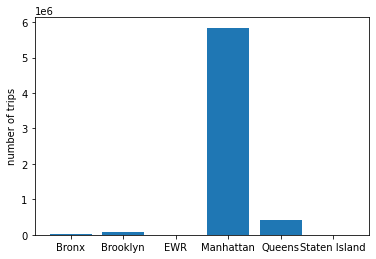

In [39]:
# we may also use matplotlib functions with dask 

tripByBoro = df.groupby('borough').count()[['DOLocationID']].compute()
plt.bar(tripByBoro.index, tripByBoro.DOLocationID.values)
plt.ylabel('number of trips')

### HW task 1

Compute and Plot 

1. Plot average number of trips as bar plots by day of week
2. Plot average total fare amount by hour of pick up time
3. Average speed by pick up hour (average speed should be calculated as total distance traveled by hour/total travel time by hour. Plot as barplot.
4. Report top 5 and bottom 5 pickup locations in terms of a) total distance, b) average speed

## Scalable Scikit-Learn

Alternatively, we can use scikit-learn for training models on medium sized data where pandas would usually fail or would take a huge amount of time.

Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation. Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code.

This is most useful for training large models on medium-sized datasets. You may have a large model when searching over many hyper-parameters, or when using an ensemble method with many individual estimators. For too small datasets, training times will typically be small enough that cluster-wide parallelism isn’t helpful. For too large datasets (larger than a single machine’s memory), the scikit-learn estimators may not be able to cope.

In [54]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

Let's now use skearn to build a simple linear model with Lasso regularization with trip cost amount as a target variable and using just trip distance as a regressor. We'll use GridSearchCV for tuning the hyperparameter (alpha) value.

In [40]:
# do some filtering to remove outliers and wrong values
df = df[(df.trip_distance > 0) & (df.trip_distance < 50)]
df = df[(df.total_amount > 0) & (df.total_amount < 300)]
df = df[(df.travel_time > 0) & (df.travel_time < 200)]

In [41]:
# X as features, y as target (note: we need to call compute method, as sklearn only takes numpy arrays)
X = df[['trip_distance','travel_time']].values.compute()
y = df.total_amount.values.compute()

Split the data into training and test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2002)

#### Create Scikit-Learn Pipeline

Pipeline consist of all the models (or intermediate steps) that we wish to train/perform on the data

In [43]:
# make a pipeline - specify the model
pipeline = Pipeline([
    ('lasso', Lasso(fit_intercept=True))])

# we can specify parameters here we want to optimize
# notice the format - {'model__parameter': range}, this format should follow for all parameters
parameters = {'lasso__alpha': 2.0**(np.arange(-10, 10, 1))}

# call the gridsearch method and fit
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


GridSearchCV(cv=3, estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02])},
             verbose=1)

In [44]:
grid_search.best_params_

{'lasso__alpha': 0.001953125}

In [45]:
# r2 score
grid_search.score(X_test, y_test)

0.863346214002065

### Homework task 2



With trip cost amount as a target variable and using trip distance, travel time and PULocationID as predictors, build a Random Forest Regression with 10 trees (n_estimators) using the sklearn pipeline to select the hyperparameter 'max_depth' with values from 2 to 5.

Use 75:25 train test split as above, use the training data for GridSearchCV with three-fold cross-validation (cv=3). Report the best max_depth as well as the R2 on test data.

In [46]:
# prepare X as features and y as target

In [47]:
# split the data

In [48]:
# create pipeline and fit the model

In [49]:
# report test accuracy